## Backtest of systematic Curve Trading strategy

### Brief Description
The aim of this document is to backtest a systematic fixed income relative value strategy for Mexican Government Peso-denominated bonds (MBONOs). The strategy seeks to capitalize on mispricings along the yield curve and across bond maturities. These dislocations arise from supply-demand imbalances, often caused by market fragmentation and the capital or regulatory constraints faced by liquidity providers. In particular, emerging markets sometimes lack arbitrage capital, allowing well-capitalized traders to exploit these inefficiencies.

The strategy implementation consists of four key elements:

1. Identification of mispriced relationships or parts of the curve and modeling their behavior.
2. Portfolio construction that isolates alpha while minimizing market risk.
3. Instrument selection and trade execution to achieve the desired position profile in the most efficient way.
4. Risk management overlay to appropriately size positions, ensuring the best risk/return profile.

I utilize the tools and procedures from my repository (https://github.com/akaufman22/mbono-firv), where all required inputs are calculated from scratch based on a historical dataset of raw market prices for Mexican government bonds.

The assumptions and mechanics of the strategy are discussed throughout the document.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import sqlite3

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as sm
from math import log, sqrt
from tqdm import tqdm
import QuantLib as ql
import scipy.optimize as sco

plt.style.use('ggplot')

Global constants for MBONO market:

In [2]:
CONVENTION = ql.Unadjusted
CALENDAR = ql.Mexico()
YIELD_BASIS = ql.Semiannual
TENOR = ql.Period(ql.Semiannual)
RULE = ql.DateGeneration.Backward
DAY_COUNT = ql.Actual360()
SETTLEMENT_DAYS = 2

Weigthing methods for constructing signals and fitting procedure for mean-reversion process:

In [3]:
#Fubnction for estimating buttefly weights based on PCA of zero curve
def get_pca_bf_weights(zc_data):
    cov = zc_data.cov()
    eig_vals, eig_vecs = np.linalg.eig(cov)
    permutation = np.argsort(-eig_vals)
    eig_vals = eig_vals[permutation]
    eig_vecs = eig_vecs[:, permutation]
    A = eig_vecs.T
    A[2] = [0, 1, 0]
    bf_weights = np.linalg.inv(A) @ np.array([[0], [0], [1]])
    return bf_weights

def get_pca_spread_weights(zc_data):
    cov = zc_data.cov()
    eig_vals, eig_vecs = np.linalg.eig(cov)
    permutation = np.argsort(-eig_vals)
    eig_vals = eig_vals[permutation]
    eig_vecs = eig_vecs[:, permutation]
    A = eig_vecs.T
    A[1] = [1, 0]
    spread_weights = np.linalg.inv(A) @ np.array([[0], [1]])
    return spread_weights

#Estimating Ornstein-Uhlenbeck parameters
def fit_ou_params(x):
    reg = sm.OLS(x[1:],sm.add_constant(x[:-1])).fit()
    theta = -log(reg.params[1])
    mu = reg.params[0] / (1 - reg.params[1])
    sigma_eq = np.std(reg.resid) / sqrt((1 - reg.params[1] ** 2))
    hl = log(2) / theta
    return theta, mu, sigma_eq, hl

Signal processing procedures and functions:

In [4]:
class MeanReversionSignal():
    
    def __init__(self, tenors, weights, time_series, mu, sigma):
        self.tenors = tenors
        self.weights = weights.flatten()
        self.time_series = time_series
        self.mu = mu
        self.sigma = sigma
        self.target_risk = None
        
    def set_trading_rule(self, ol=-2, cl=-1, os=2, cs=1, ts=30):
        self.open_long = ol
        self.close_long = cl
        self.open_short = os
        self.close_short = cs
        self.time_stop = ts
        return self
    
    def estimate_target_risk(self):
        signal = (self.time_series - self.mu)/self.sigma
        discrete_signal = discretise_signal(signal, self.open_long, self.close_long, self.open_short, self.close_short)
        target_risk= np.repeat(self.weights.reshape(1,-1), len(signal), axis=0) * discrete_signal.to_numpy().reshape(-1,1)
        target_risk = pd.DataFrame(data=target_risk,
                                   index=self.time_series.index, columns=self.tenors)
        self.target_risk = target_risk
        return self
    
    def dumb_pnl(self, market_data):
        pnl = ((market_data.diff().shift(-1)) * self.target_risk).sum(axis=1)
        return pnl
    
class AggregatedSignal():
    
    def __init__(self, strategies, weights=None, dates=None):
        self.strategies = strategies
        if weights is None:
            weights = np.ones(len(strategies))
        self.weights = weights
        self.multiplier = 1
        self.target_risk = None
        self.dates = dates

    def estimate_target_risk(self):
        print('Aggregating Signals')
        if self.strategies[0].target_risk is None:
            self.strategies[0].estimate_target_risk()
        target_risk = self.strategies[0].target_risk * self.weights[0]
        for i in range(1, len(self.strategies)):
            if self.strategies[i].target_risk is None:
                self.strategies[i].estimate_target_risk()
            target_risk = target_risk.add(self.strategies[i].target_risk * self.weights[i],
                                            fill_value=0)
        target_risk.fillna(0, inplace=True)
        target_risk *= self.multiplier
        if self.dates is not None:
            target_risk = target_risk.reindex(self.dates, fill_value=0)
        self.target_risk = target_risk
        return self
    
    def dumb_pnl(self, market_data):
        pnl = ((market_data.diff().shift(-1)) * self.target_risk).sum(axis=1)
        return pnl
    
    def set_target_volatility(self, target_volatility, zc_curves):
        print('Setting Target Volatility')
        if self.target_risk is None:
            self.get_target_risk()
        self.target_volatility = target_volatility
        for d in tqdm(self.target_risk.index):
            d2 = d + pd.tseries.offsets.DateOffset(days=-1)
            d1 = d2 + pd.tseries.offsets.DateOffset(years=-1)
            idx = zc_curves.index.intersection(pd.bdate_range(d1, d2))
            rolling_history = zc_curves.diff().loc[idx, self.target_risk.columns].to_numpy()
            cov = np.cov(rolling_history.T)
            vol = np.sqrt(261) * np.sqrt(np.dot(np.dot(self.target_risk.loc[d].to_numpy(), cov), self.target_risk.loc[d].to_numpy().T))
            if vol != 0:
                self.target_risk.loc[d] = self.target_risk.loc[d] * target_volatility / vol
        return self
    
def discretise_signal(z_scores, ol=-2, cl=-1, os=2, cs=1):
    position = pd.Series(0, index=z_scores.index)
    position.iloc[0] = np.where(z_scores.iloc[0] <= ol, 1, np.where(z_scores.iloc[0] >= os, -1, 0))
    for i in range(1, len(z_scores.index)):
        position.iloc[i] = np.where(z_scores.iloc[i] <= ol, 1, np.where(z_scores.iloc[i] >= os, -1,
            np.where((z_scores.iloc[i] < cl) & (position.iloc[i-1] == 1), 1,
            np.where((z_scores.iloc[i] > cs) & (position.iloc[i-1] == -1), -1, 0))))
    return position

Class for the Monetisation strategy, which takes signals as desired risk exposures and translates them into trades and positions in terms of traded instruments:

In [5]:
class SystematicStrategy():
    
    def __init__ (self, strategy, instrument_universe, market_data, zc_curves,
                  rebal_threshold=0, trading_threshold=0, time_slippage=0, fit_resid=None,
                  rebal_rule='vol', calendar=ql.Mexico(), day_count=ql.Actual360(),
                  settlement_days=2, yield_basis=ql.Semiannual):
        self.strategy = strategy
        self.instrument_universe = instrument_universe
        self.market_data = market_data
        self.zc_curves = zc_curves
        self.rebal_threshold = rebal_threshold
        self.trading_threshold = trading_threshold
        self.time_slippage = time_slippage
        self.tenors = self.zc_curves.columns
        self.tenors_years = [int(s[1:]) for s in self.tenors]
        self.fit_resid = fit_resid
        self.rebal_rule = rebal_rule
        self.calendar = calendar
        self.day_count = day_count
        self.settlement_days = settlement_days
        self.yield_basis = yield_basis
        
    def get_ql_obj(self, date):
        ql_date = ql.Date(date.day, date.month, date.year)
        ql.Settings.instance().evaluationDate = ql_date
        zero_curve = self.zc_curves.loc[date]
        spot_rates = [zero_curve.values[0]] + list(zero_curve.values)
        spot_dates = [ql_date + ql.Period(int(t), ql.Years) for t in ([0] + self.tenors_years)]
        spot_curve = ql.ZeroCurve(spot_dates, spot_rates, self.day_count, self.calendar)
        spot_curve_handle = ql.YieldTermStructureHandle(spot_curve)
        return spot_curve_handle

    def estimate_risk(self, position, date, spot_curve_handle):
        risk = pd.Series(index=self.tenors,
                         data=portfolio_risk(self.instrument_universe, date, position, spot_curve_handle,
                              self.tenors_years))
        return risk
    
    def order_to_open(self, date, risk, ql_curve_handle):
        if self.fit_resid is None:
            fit_data = None
        else:
            fit_data = self.fit_resid.loc[date]
        order = trading_order(self.instrument_universe, date, risk, ql_curve_handle,
                              self.tenors_years, fit_data=fit_data)
        return order    
    
    def rebalance_order(self, position, target_risk, date, spot_curve_handle):
        position_risk = self.estimate_risk(position, date, spot_curve_handle)
        tracking_error = position_risk - target_risk
        d2 = date + pd.tseries.offsets.DateOffset(days=-1)
        d1 = d2 + pd.tseries.offsets.DateOffset(years=-1)
        idx = self.zc_curves.index.intersection(pd.bdate_range(d1, d2))
        cov = np.cov(self.zc_curves.diff().loc[idx].T)
        if self.rebal_rule == 'vol':
            risk_dev = np.sqrt(261) * np.sqrt(np.dot(np.dot(tracking_error.to_numpy(), cov), tracking_error.to_numpy().T))
        elif self.rebal_rule == 'l2':
            risk_dev = np.sqrt(np.sum(tracking_error ** 2))
        if risk_dev > self.rebal_threshold:
            target_position = self.order_to_open(date, target_risk, spot_curve_handle)
            order = target_position.subtract(position, fill_value=0)
        else:
            order = pd.Series(index=position.index, data=0)
        return order
    
    def calc_position(self, min_lot=0):
        print('Calculating Position')
        if self.strategy.target_risk is None:
            self.strategy.estimate_target_risk()
        strategy_risk = self.strategy.target_risk
        target_risk = pd.DataFrame(columns = self.tenors, index = strategy_risk.index, data=0)
        target_risk.loc[strategy_risk.index, strategy_risk.columns] = strategy_risk
        df_position = pd.DataFrame(index=target_risk.index, columns=self.instrument_universe.index, data=0)
        df_risk = pd.DataFrame(index=target_risk.index, columns=target_risk.columns, data=0)
        df_trades = pd.DataFrame(index=target_risk.index, columns=self.instrument_universe.index, data=0)
        d = target_risk.index[0]
        spot_curve_handle = self.get_ql_obj(d)
        target_order = self.order_to_open(d, target_risk.loc[d], spot_curve_handle)
        df_trades.loc[d, target_order.index] = target_order * (target_order.abs() > min_lot)
        df_position.loc[d] = df_trades.loc[d]
        df_risk.loc[d] = self.estimate_risk(df_position.loc[d], d, spot_curve_handle)
        for i in tqdm(range(1, len(target_risk.index))):
            d = target_risk.index[i]
            d_signal = target_risk.index[i-self.time_slippage]
            spot_curve_handle = self.get_ql_obj(d)
            df_position.loc[d] = df_position.shift(1).loc[d]
            target_order = self.rebalance_order(df_position.loc[d], target_risk.loc[d_signal], d, spot_curve_handle)
            df_trades.loc[d, target_order.index] = target_order * (target_order.abs() > min_lot)
            df_position.loc[d] += df_trades.loc[d]
            current_risk = self.estimate_risk(df_position.loc[d], d, spot_curve_handle)
            df_risk.loc[d] = current_risk
        self.position = df_position
        self.risk = df_risk
        self.trades = df_trades
        return self.position, self.risk, self.trades
        
    def calc_total_pnl(self, tcosts=0):
        self.tcosts = tcosts
        repo_rates = self.zc_curves.loc[self.position.index, ['Y1']]
        index_name = self.position.index.name
        sett_dates = list(self.position.reset_index()[index_name].apply(ql.Date().from_date).map(
            lambda x: self.calendar.advance(x, self.settlement_days, ql.Days)))
        df_position_nonzero = self.position.loc[:, (self.position != 0).any(axis=0)].copy()
        df_settlement = pd.DataFrame(index=self.position.index, columns=['Settle Date'], data=sett_dates)
        df_settlement['Funding Days'] = df_settlement['Settle Date'].diff().shift(-1)
        df_sett_position = self.position.copy()
        df_sett_position.index = sett_dates
        repo_rates.index = sett_dates
        repo_rates = repo_rates.iloc[:,0]
        df_dirty_prices = pd.DataFrame(index=self.position.index, columns=self.market_data.columns, data=0)
        df_tcosts = pd.DataFrame(index=self.trades.index, columns=self.market_data.columns, data=0)
        df_coupons = pd.DataFrame(index=self.position.index, columns=self.position.columns, data=0)
        for b in df_position_nonzero.columns:
            bond = self.instrument_universe.loc[b, 'QL bond']
            coupon_dates = []
            coupon_amounts = []
            for c in bond.cashflows()[:-1]:
                coupon_dates.append(c.date())
                coupon_amounts.append(c.amount())
            for d in self.position.index:
                ql_d = ql.Date().from_date(d)
                ql_d_settle = df_settlement.loc[d, 'Settle Date']
                if ql_d_settle in coupon_dates:
                    df_coupons.loc[d, b] = coupon_amounts[coupon_dates.index(ql_d_settle)]
                df_dirty_prices.loc[d, b] = self.market_data.loc[d, b] + \
                    bond.accruedAmount(self.calendar.advance(ql_d, self.settlement_days, ql.Days))
                try:
                    df_tcosts.loc[d, b] = self.market_data.loc[d, b] - bond.cleanPrice(
                        bond.bondYield(self.market_data.loc[d, b], self.day_count, self.yield_basis, ql.Compounded) + self.tcosts/4,
                        self.day_count, self.yield_basis, ql.Compounded)
                except:
                    df_tcosts.loc[d, b] = 0
        self.coupons = df_coupons * self.position.shift(1) / 100
        df_sett_position.index = df_settlement.index
        repo_rates.index = df_settlement.index
        self.funding = -(df_sett_position * df_dirty_prices / 100).mul(
            repo_rates, axis=0).mul(
                df_settlement['Funding Days'], axis=0) / 360
        self.tcosts = -df_tcosts * self.trades.abs() / 100
        self.pnl = ((self.position.shift(1) * df_dirty_prices.diff() / 100)+self.funding+self.coupons + self.tcosts)
        self.dirty_prices = df_dirty_prices
        self.tcosts_all = df_tcosts
        return self.pnl.sum(axis=1)

def trading_order(instruments, date, risk_to_trade, spot_curve_handle, curve_tenors_years,
                  fit_data=None, fit_threshold=0.01, maturity_band=0.2):
    ql_date = ql.Date(date.day, date.month, date.year)
    ql.Settings.instance().evaluationDate = ql_date
    curve_tenors = ['Y'+str(t) for t in curve_tenors_years]
    sensitivities = instruments[instruments['PricingDate'] < date].copy()
    for i in sensitivities.index:
        bond = sensitivities.loc[i, 'QL bond']
        sensitivities.loc[i, curve_tenors] = bond_sensitivities(bond, date, spot_curve_handle, curve_tenors_years)
    risk = pd.Series(index= curve_tenors, data=0)
    risk.loc[risk_to_trade.index] = risk_to_trade
    if fit_data is not None:
        benchmarks = []
        to_keep = fit_data[fit_data.abs() <= fit_threshold].index
        sensitivities = sensitivities.loc[to_keep.intersection(sensitivities.index)]
        for t in curve_tenors:
            years = int(t[1:])
            tenor_date = date + pd.tseries.offsets.DateOffset(years=years)
            mask = (abs((sensitivities['Maturity'] - tenor_date).dt.days) < maturity_band*years*365)
            subuniverse = sensitivities.loc[mask]
            candidates = list(subuniverse.index)
            if len(candidates) == 0:
                benchmarks.append(sensitivities[t].abs().idxmax())
            else:
                benchmarks.append((np.sign(risk_to_trade[t]) * fit_data[candidates]).idxmin())
        benchmarks = list(set(benchmarks))
    else:
        benchmarks = list(set([sensitivities[t].abs().idxmax() for t in curve_tenors]))
    order = pd.Series(index = benchmarks,
                    data=100 * np.linalg.lstsq(sensitivities.loc[benchmarks, curve_tenors].to_numpy().T, risk.to_numpy(), rcond=None)[0])
    return order

def portfolio_risk(instruments, date, portfolio, spot_curve_handle, tenors_years):
    risk = np.array([0.0] * len(tenors_years))
    for i in portfolio.index:
        bond = instruments.loc[i, 'QL bond']
        risk += bond_sensitivities(bond, date, spot_curve_handle, tenors_years) * portfolio.loc[i] / 100
    return risk

def bond_sensitivities(bond, date, spot_curve_handle, tenors_years):
    ql_date = ql.Date(date.day, date.month, date.year)
    ql.Settings.instance().evaluationDate = ql_date
    bumps = [ql.SimpleQuote(0.00) for n in ([0] + tenors_years)]
    spreads = [ql.QuoteHandle(bump) for bump in bumps]
    spot_dates = [ql_date + ql.Period(int(t), ql.Years) for t in ([0] + tenors_years)]
    spreaded_yts = ql.YieldTermStructureHandle(
        ql.SpreadedLinearZeroInterpolatedTermStructure(spot_curve_handle, spreads, spot_dates))
    spreaded_yts.enableExtrapolation()
    bond.setPricingEngine(ql.DiscountingBondEngine(spreaded_yts))
    price = bond.cleanPrice()
    senstivities = []
    for bump in bumps[1:]:
        bump.setValue(0.0001)
        senstivities.append(bond.cleanPrice() - price)
        bump.setValue(0.00)
    return np.array(senstivities)



In [6]:
def define_ql_bonds_bulk(instrument_ids, id_type='BBGID'):
    con = sqlite3.connect("./db/MBONOdata.db")
    str_ids = '('+str(instrument_ids)[1:-1]+')'
    bonds_sample = []
    query = """SELECT Instruments.%s, StaticSchedules.Date,
    StaticSchedules.Coupon, StaticSchedules.Principal
    FROM StaticSchedules INNER JOIN Instruments
    ON StaticSchedules.InstrumentID = Instruments.InstrumentID
    WHERE Instruments.%s in %s;""" % (id_type, id_type, str_ids)
    aggregate_schedules = pd.read_sql_query(query, con, parse_dates=['Date'])
    for b in instrument_ids:
        bond_schedule = aggregate_schedules[
            aggregate_schedules[id_type] == b].copy().sort_values('Date')
        bond_schedule['Days'] = (bond_schedule['Date'] -
                                 bond_schedule['Date'].shift(1)).dt.days
        schedule = ql.Schedule(bond_schedule['Date'].apply(
            ql.Date().from_date).values, CALENDAR,
                           CONVENTION, CONVENTION, TENOR, RULE, False)
        face_value = sum(bond_schedule['Principal'])
        coupons = ((360 / bond_schedule['Days']) * bond_schedule['Coupon'] /
                   face_value).dropna().values
        bonds_sample.append(ql.FixedRateBond(SETTLEMENT_DAYS, 100,
                                             schedule, coupons, DAY_COUNT))
    return bonds_sample

Loading and preparing the data: defining instument objects, loading zero curves, market prices, curve fit metrics etc

In [7]:
df_zc = pd.read_csv('./ZeroCurve.csv', parse_dates=[0], index_col=0).sort_index()
df_zc.columns = ['Y' + str(i) for i in df_zc.columns]
df_zc.index.name = 'Date'
df_zc.head()

,Y1,Y2,Y3,Y5,Y7,Y10,Y15,Y20,Y30
Date,,,,,,,,,
2010-01-01,0.049139,0.059082,0.066124,0.074606,0.079008,0.082525,0.086468,0.090251,0.096812
2010-01-04,0.048706,0.059136,0.066494,0.075229,0.079574,0.082800,0.086405,0.090291,0.097765
2010-01-05,0.051110,0.058690,0.066621,0.075089,0.079097,0.082451,0.086078,0.089435,0.098320
2010-01-06,0.050152,0.059206,0.066920,0.074806,0.078709,0.082246,0.086287,0.089779,0.097143
2010-01-07,0.048686,0.059434,0.066632,0.074840,0.078968,0.082336,0.086170,0.089791,0.096544


In [8]:
con = sqlite3.connect("./db/MBONOdata.db")
query = """SELECT DISTINCT BBGId, InstrumentID, Maturity, PricingDate from Instruments WHERE Maturity > 2010-01-01;"""
df = pd.read_sql_query(query, con, parse_dates=['PricingDate', 'Maturity'])
bonds = define_ql_bonds_bulk(list(df['BBGID'].values), id_type='BBGID')
df['QL bond'] = bonds
df.set_index('BBGID', inplace=True)
df.head()

,InstrumentID,Maturity,PricingDate,QL bond
BBGID,,,,
EC4262522 Corp,6,2011-07-14,2001-07-20,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...
EC6223613 Corp,10,2009-07-09,2002-07-12,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...
EC8045386 Corp,12,2009-12-24,2002-12-27,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...
EC8084633 Corp,13,2012-12-20,2003-01-03,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...
ED2028832 Corp,15,2023-12-07,2003-10-24,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...


In [9]:
query = """SELECT InstrumentID,  Date, Price FROM MarketData ;"""
agg_price_data = pd.read_sql_query(query, con, parse_dates=['Date']).sort_values(['Date'])
price_data = agg_price_data.pivot_table(index='Date', columns='InstrumentID', values='Price')
price_data.columns = [df.index[df['InstrumentID'] == c][0] for c in price_data.columns]
price_data.head()

,EC4262522 Corp,EC8045386 Corp,EC8084633 Corp,ED2028832 Corp,ED2746086 Corp,ED2816525 Corp,ED7597518 Corp,ED7791103 Corp,ED7894840 Corp,EF2270975 Corp,...,EK1693424 Corp,EI7361336 Corp,QJ1649335 Corp,AM7523740 Corp,AS2511341 Corp,AX6352725 Corp,ZR8833868 Corp,BR4592233 Corp,BS4948482 Corp,BX4963407 Corp
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,108.040,100.011,106.456,97.457,102.788,103.646,109.157,114.879,106.560,102.930,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,108.045,100.011,106.240,97.553,102.804,103.390,108.919,114.605,106.521,102.383,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,108.057,100.011,106.251,97.814,102.790,103.383,108.901,114.911,106.493,102.395,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,108.099,100.011,106.317,97.862,102.783,103.377,108.945,115.047,106.483,102.438,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,108.074,100.011,106.421,97.907,102.771,103.481,109.026,114.992,106.471,102.539,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
query = """SELECT InstrumentID,  Date, Residual FROM FitData ;"""
agg_fit_data = pd.read_sql_query(query, con, parse_dates=['Date']).sort_values(['Date'])
fit_data = agg_fit_data.pivot_table(index='Date', columns='InstrumentID', values='Residual')
fit_data.columns = [df.index[df['InstrumentID'] == c][0] for c in fit_data.columns]
fit_data.head()

,EC4262522 Corp,EC8084633 Corp,ED2028832 Corp,ED2746086 Corp,ED2816525 Corp,ED7597518 Corp,ED7791103 Corp,ED7894840 Corp,EF2270975 Corp,EF5478096 Corp,...,EK1693424 Corp,EI7361336 Corp,QJ1649335 Corp,AM7523740 Corp,AS2511341 Corp,AX6352725 Corp,ZR8833868 Corp,BR4592233 Corp,BS4948482 Corp,BX4963407 Corp
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,-0.004205,0.000866,0.000246,0.001868,-0.000460,-0.000070,-0.000353,-0.003555,-0.001657,0.001410,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,-0.004120,0.001318,-0.000007,0.002118,-0.000227,-0.000095,-0.000196,-0.003388,-0.001114,0.000812,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,-0.004285,0.001036,-0.000109,-0.000957,-0.000428,-0.000060,-0.000277,-0.003048,-0.000915,0.000322,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,-0.004713,0.000510,-0.000162,0.000188,-0.000374,0.000061,-0.000439,-0.003443,-0.000682,0.000156,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,-0.004839,0.000492,-0.000138,0.002286,-0.000367,-0.000046,-0.000309,-0.003523,-0.000962,0.000314,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Signal Construction
Now that the input data is prepared, I can construct the signals. I use a moving 5-year trailing window for estimation and a moving 1-year forward window for out-of-sample testing. In total, this provides almost 13 years of out-of-sample observations.

To construct signals, I use PCA-derived factors. In [this notebook](https://github.com/akaufman22/mbono-firv/blob/main/SystematicButterflyTrading.ipynb), I discuss alternative approaches and conclude that PCA likely provides the best weighting scheme. First, I estimate the signals based on portfolios that are neutral to the first two principal components, which produce (weighted) butterflies. For potential trades, if the criteria for mean reversion (based on test p-value, asymptotic variance, and speed of mean reversion) are satisfied, a signal is generated based on the Z-score.

In [11]:
tenors = ['Y2', 'Y3', 'Y5', 'Y7', 'Y10', 'Y15', 'Y20']

lookback_years = 5
test_years = 1
p_val_crit = 0.1
hl_crit = 30
sigma_crit = 0.0003
z_ol = -2
z_cl = -.5
z_os = 2
z_cs = .5

eoy = pd.date_range(end=df_zc.index[-1], start = df_zc.index[0], freq='BY')
pca_strategies = []
                
for i in tqdm(range(lookback_years-1, len(eoy), 1)):
    idx = pd.bdate_range(start=eoy[i] + pd.tseries.offsets.DateOffset(years=-lookback_years), end=eoy[i])
    train_idx = df_zc.index.intersection(idx)
    idx = pd.bdate_range(end=eoy[i] + pd.tseries.offsets.DateOffset(years=test_years),
                        start=eoy[i] + pd.tseries.offsets.DateOffset(days=1))
    test_idx = df_zc.index.intersection(idx)
    for j, t1 in enumerate(tenors):
        for k, t2 in enumerate(tenors[j+1:j+2]):
            for t3 in tenors[j+k+2:j+k+3]:
                pca_bf_weights = get_pca_bf_weights(df_zc.loc[train_idx, [t1, t2, t3]])
                pca_bf_ts = df_zc.loc[train_idx, [t1, t2, t3]].dot(pca_bf_weights)
                if adfuller(pca_bf_ts)[1] < p_val_crit:
                    _, mu, sigma_eq, hl  = fit_ou_params(pca_bf_ts.values)
                    if (hl < hl_crit) & (sigma_eq > sigma_crit):
                        print(test_idx[0], t1, t2, t3, int(hl), int(10000*sigma_eq))
                        pca_bf_test = df_zc.loc[test_idx, [t1, t2, t3]].dot(pca_bf_weights)
                        pca_strategy = MeanReversionSignal([t1, t2, t3], pca_bf_weights, pca_bf_test, mu, sigma_eq)
                        pca_strategy.set_trading_rule(ol=z_ol, cl=z_cl, os=z_os, cs=z_cs, ts=30)
                        pca_strategies.append(pca_strategy)

 12%|█▎        | 1/8 [00:00<00:03,  2.19it/s]

2015-01-01 00:00:00 Y2 Y3 Y5 1 4
2015-01-01 00:00:00 Y3 Y5 Y7 5 3
2015-01-01 00:00:00 Y10 Y15 Y20 2 5


 25%|██▌       | 2/8 [00:00<00:02,  3.00it/s]

2016-01-01 00:00:00 Y2 Y3 Y5 1 3
2016-01-01 00:00:00 Y3 Y5 Y7 6 4
2016-01-01 00:00:00 Y10 Y15 Y20 2 5


 38%|███▊      | 3/8 [00:00<00:01,  3.39it/s]

2017-01-02 00:00:00 Y2 Y3 Y5 1 4
2017-01-02 00:00:00 Y3 Y5 Y7 4 3
2017-01-02 00:00:00 Y10 Y15 Y20 1 4


 50%|█████     | 4/8 [00:01<00:01,  3.55it/s]

2018-01-01 00:00:00 Y2 Y3 Y5 1 4
2018-01-01 00:00:00 Y3 Y5 Y7 3 3
2018-01-01 00:00:00 Y7 Y10 Y15 5 4
2018-01-01 00:00:00 Y10 Y15 Y20 1 4


 62%|██████▎   | 5/8 [00:01<00:00,  3.68it/s]

2019-01-01 00:00:00 Y2 Y3 Y5 1 4
2019-01-01 00:00:00 Y7 Y10 Y15 2 3


 75%|███████▌  | 6/8 [00:01<00:00,  3.70it/s]

2020-01-01 00:00:00 Y2 Y3 Y5 1 3


 88%|████████▊ | 7/8 [00:01<00:00,  3.82it/s]

2021-01-01 00:00:00 Y2 Y3 Y5 2 4
2021-01-01 00:00:00 Y3 Y5 Y7 8 3


100%|██████████| 8/8 [00:02<00:00,  3.61it/s]

2022-01-03 00:00:00 Y2 Y3 Y5 3 3
2022-01-03 00:00:00 Y3 Y5 Y7 8 3
2022-01-03 00:00:00 Y10 Y15 Y20 1 4


Now I repeat the previous step for the portfolios that are only netral to the first pricnipal component. In this case weighted spreads (steepeners or flatteners) are produced and all other steps are the same.

In [12]:
tenors = ['Y2', 'Y3', 'Y5', 'Y7', 'Y10', 'Y15', 'Y20']
#tenors = ['Y3', 'Y5', 'Y10']

lookback_years = 5
test_years = 1
p_val_crit = 0.1
hl_crit = 60
sigma_crit = 0.001
z_ol = -2
z_cl = -0.5
z_os = 2
z_cs = 0.5

eoy = pd.date_range(end=df_zc.index[-1], start = df_zc.index[0], freq='BY')
pca_spread_strategies =[]
                
for i in tqdm(range(lookback_years-1, len(eoy), 1)):
    idx = pd.bdate_range(start=eoy[i] + pd.tseries.offsets.DateOffset(years=-lookback_years), end=eoy[i])
    train_idx = df_zc.index.intersection(idx)
    idx = pd.bdate_range(end=eoy[i] + pd.tseries.offsets.DateOffset(years=test_years),
                        start=eoy[i] + pd.tseries.offsets.DateOffset(days=1))
    test_idx = df_zc.index.intersection(idx)
    for j, t1 in enumerate(tenors):
        for k, t2 in enumerate(tenors[j+1:j+5]):
            pca_spread_weights = get_pca_spread_weights(df_zc.loc[train_idx, [t1, t2]])
            pca_spread_ts = df_zc.loc[train_idx, [t1, t2]].dot(pca_spread_weights)
            if adfuller(pca_spread_ts)[1] < p_val_crit:
                _, mu, sigma_eq, hl  = fit_ou_params(pca_spread_ts.values)
                if (hl < hl_crit) & (sigma_eq > sigma_crit):
                    print(test_idx[0], t1, t2, int(hl), int(10000*sigma_eq))
                    pca_spread_test = df_zc.loc[test_idx, [t1, t2]].dot(pca_spread_weights)
                    strategy = MeanReversionSignal([t1, t2], pca_spread_weights, pca_spread_test, mu, sigma_eq)
                    strategy.set_trading_rule(ol=z_ol, cl=z_cl, os=z_os, cs=z_cs, ts=30)
                    pca_spread_strategies.append(strategy)

  0%|          | 0/8 [00:00<?, ?it/s]

2015-01-01 00:00:00 Y5 Y10 37 25
2015-01-01 00:00:00 Y5 Y15 39 39
2015-01-01 00:00:00 Y5 Y20 18 50
2015-01-01 00:00:00 Y7 Y10 25 14
2015-01-01 00:00:00 Y7 Y15 25 31
2015-01-01 00:00:00 Y10 Y15 15 20


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

2016-01-01 00:00:00 Y5 Y15 50 32
2016-01-01 00:00:00 Y7 Y10 25 12


 38%|███▊      | 3/8 [00:01<00:03,  1.57it/s]

2018-01-01 00:00:00 Y2 Y3 5 15
2018-01-01 00:00:00 Y2 Y5 20 43
2018-01-01 00:00:00 Y2 Y7 44 67
2018-01-01 00:00:00 Y3 Y5 35 24


 50%|█████     | 4/8 [00:02<00:02,  1.42it/s]

2019-01-01 00:00:00 Y2 Y3 2 11
2019-01-01 00:00:00 Y2 Y5 11 30
2019-01-01 00:00:00 Y2 Y7 28 48
2019-01-01 00:00:00 Y2 Y10 49 72
2019-01-01 00:00:00 Y3 Y5 24 17
2019-01-01 00:00:00 Y3 Y7 46 33
2019-01-01 00:00:00 Y5 Y10 42 28
2019-01-01 00:00:00 Y5 Y20 54 69
2019-01-01 00:00:00 Y7 Y10 32 13
2019-01-01 00:00:00 Y7 Y15 44 32
2019-01-01 00:00:00 Y7 Y20 41 48
2019-01-01 00:00:00 Y10 Y15 26 16
2019-01-01 00:00:00 Y10 Y20 22 31


 62%|██████▎   | 5/8 [00:03<00:02,  1.15it/s]

2019-01-01 00:00:00 Y15 Y20 10 13
2020-01-01 00:00:00 Y2 Y3 6 11
2020-01-01 00:00:00 Y2 Y7 47 46
2020-01-01 00:00:00 Y5 Y15 53 34
2020-01-01 00:00:00 Y5 Y20 50 43
2020-01-01 00:00:00 Y7 Y10 28 10
2020-01-01 00:00:00 Y7 Y15 28 21
2020-01-01 00:00:00 Y7 Y20 30 29
2020-01-01 00:00:00 Y10 Y15 14 11


 75%|███████▌  | 6/8 [00:04<00:01,  1.09it/s]

2020-01-01 00:00:00 Y10 Y20 15 19
2021-01-01 00:00:00 Y2 Y3 6 11
2021-01-01 00:00:00 Y2 Y5 15 24
2021-01-01 00:00:00 Y2 Y7 25 34
2021-01-01 00:00:00 Y2 Y10 40 51
2021-01-01 00:00:00 Y3 Y5 22 13
2021-01-01 00:00:00 Y3 Y7 32 24
2021-01-01 00:00:00 Y3 Y10 51 41
2021-01-01 00:00:00 Y5 Y7 34 10
2021-01-01 00:00:00 Y5 Y10 47 26
2021-01-01 00:00:00 Y7 Y10 41 14
2021-01-01 00:00:00 Y7 Y15 47 35
2021-01-01 00:00:00 Y7 Y20 55 53
2021-01-01 00:00:00 Y10 Y15 32 18


 88%|████████▊ | 7/8 [00:05<00:00,  1.19it/s]

2022-01-03 00:00:00 Y2 Y5 32 28
2022-01-03 00:00:00 Y2 Y7 43 39
2022-01-03 00:00:00 Y2 Y10 50 58
2022-01-03 00:00:00 Y3 Y5 24 15
2022-01-03 00:00:00 Y3 Y7 34 27
2022-01-03 00:00:00 Y3 Y10 48 46
2022-01-03 00:00:00 Y3 Y15 58 82
2022-01-03 00:00:00 Y5 Y7 33 11
2022-01-03 00:00:00 Y5 Y10 43 28
2022-01-03 00:00:00 Y5 Y15 54 58
2022-01-03 00:00:00 Y5 Y20 26 89
2022-01-03 00:00:00 Y7 Y10 39 15
2022-01-03 00:00:00 Y7 Y15 45 40
2022-01-03 00:00:00 Y7 Y20 22 64
2022-01-03 00:00:00 Y10 Y15 30 21
2022-01-03 00:00:00 Y10 Y20 14 39


100%|██████████| 8/8 [00:06<00:00,  1.19it/s]


### Monetization
To construct the strategy, I aggregate the signals separately for butterflies and spreads, weighting them by inverse volatility. Finally, positions are sized to target a fixed volatility level of returns. In this iteration, I consider daily rebalancing with a buffer (tracking error volatility threshold) set to zero. When rebalancing a specific bucket exposure is necessary, the system selects the cheapest (or richest) bond in the relevant part of the curve for execution. The richness or cheapness of an individual bond is defined by its spread to a theoretical fitted curve, with outliers (10bp+ absolute yield deviation) excluded.

### Backtest
The backtest is subject to several assumptions:

1. Transaction costs are set at 0.5bp, representing the bid/offer spread in yield terms for executing a butterfly trade or steepener/flattener. I also calculate performance at different transaction cost levels later.

2. Slippage is set to one day, representing the time difference between obtaining a signal and executing a trade based on it. This assumption is likely too conservative for butterfly trading, as the signal's half-life is very short. In practice, slippage could be just a few minutes, but my current data set is in daily frequency. I adopt this conservative approach, though zero slippage would likely produce more realistic results.

3. All bonds are assumed to be good collateral and available for borrowing. The cost of funding the position is assumed to be uniform across all securities and determined by the short end of the curve. Since outliers are excluded during execution, I am not concerned about bonds trading special.

4. No taxes or costs are applied to coupons. All received or paid coupons are accounted for at 100% of their value.

In [13]:
agg_butterflies = AggregatedSignal(pca_strategies, dates=df_zc.loc['2015':].index)
agg_butterflies.estimate_target_risk()
agg_butterflies.set_target_volatility(1, df_zc)
agg_spreads = AggregatedSignal(pca_spread_strategies, dates=df_zc.loc['2015':].index)
agg_spreads.estimate_target_risk()
agg_spreads.set_target_volatility(1, df_zc)
agg_strategy = AggregatedSignal([agg_butterflies, agg_spreads], dates=df_zc.loc['2015':].index)
agg_strategy.estimate_target_risk()
agg_strategy.set_target_volatility(200, df_zc)
pca_trading = SystematicStrategy(agg_strategy, df, price_data, df_zc, rebal_threshold=0, fit_resid=fit_data, time_slippage=1)
pca_trading.calc_position()
pca_trading.calc_total_pnl()
pca_gr_total_pnl = pca_trading.pnl.sum(axis=1) 
pca_trading.calc_total_pnl(tcosts=0.00005)
pca_net_total_pnl = pca_trading.pnl.sum(axis=1)
pca_total_pnl = [pca_gr_total_pnl, pca_net_total_pnl]

Aggregating Signals
Setting Target Volatility


100%|██████████| 2058/2058 [00:14<00:00, 145.26it/s]


Aggregating Signals
Setting Target Volatility


100%|██████████| 2058/2058 [00:14<00:00, 146.43it/s]


Aggregating Signals
Setting Target Volatility


100%|██████████| 2058/2058 [00:13<00:00, 154.18it/s]


Calculating Position


100%|██████████| 2057/2057 [04:29<00:00,  7.65it/s]


Below there are some descriptive statistics and ratios for unoptimized version of the strategy which later can be tailored to a particular mandate or risk limitations:

,Before Costs,After Costs
"Avg GMV, $","508,332,379","508,332,379"
"Avg Ann PNL, $","8,425,125","6,721,120"
"Ann Std Dev, $","3,833,983","3,809,020"
"Return on GMV, %",1.66%,1.32%
"Daily Turnover Ratio, %",42.10%,42.10%
Sharpe Ratio,2.20,1.76
Sortino Ratio,4.05,3.16
"Max Drawdown, $","-2,314,356","-2,314,939"
"1D VaR (95%), $","-251,591","-257,520"


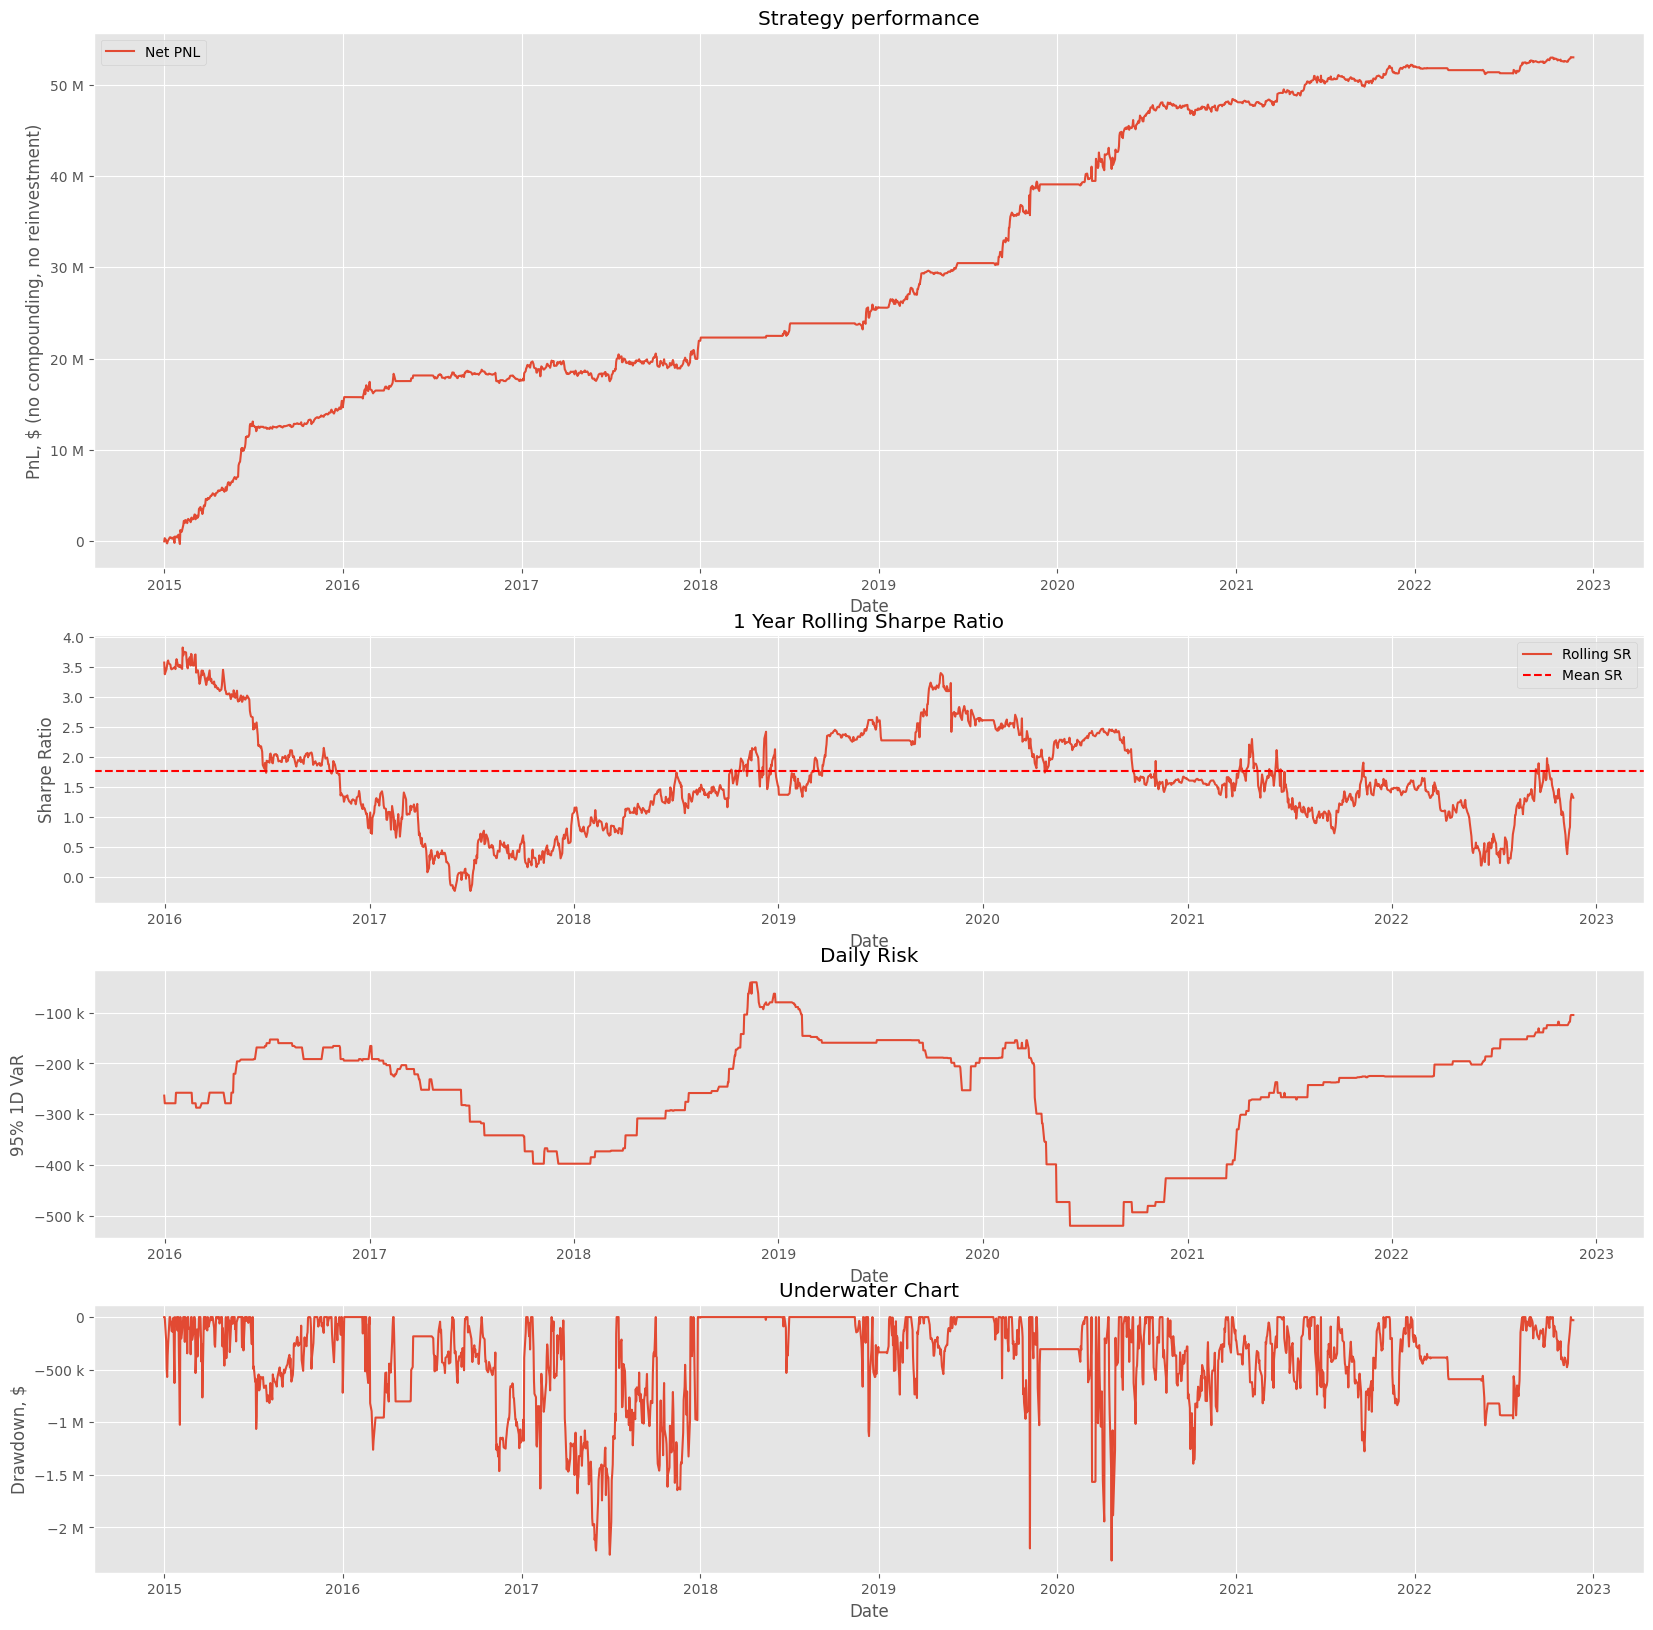

In [14]:
total_pnl = [pca_gr_total_pnl, pca_net_total_pnl]
strat_stats = ['Avg GMV, $', 'Avg Ann PNL, $', 'Ann Std Dev, $', 'Return on GMV, %',
               'Daily Turnover Ratio, %',
               'Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown, $', '1D VaR (95%), $']
df_stats = pd.DataFrame(index=strat_stats, columns=['Before Costs', 'After Costs'])
for i in range(2):
    df_stats.iloc[0, i] = (pca_trading.position * pca_trading.dirty_prices/100).abs().sum(axis=1).mean()
    df_stats.iloc[1, i] = total_pnl[i].mean() * 261
    df_stats.iloc[2, i] = total_pnl[i].std() * np.sqrt(261)
    df_stats.iloc[3, i] = df_stats.iloc[1, i] / df_stats.iloc[0, i] 
    df_stats.iloc[4, i] = (pca_trading.trades * pca_trading.dirty_prices).abs().sum(axis=1).sum() / \
        (pca_trading.position * pca_trading.dirty_prices).abs().sum(axis=1).sum()
    df_stats.iloc[5, i] = df_stats.iloc[1, i] / df_stats.iloc[2, i]
    df_stats.iloc[6, i] = df_stats.iloc[1, i] / np.sqrt(np.sum(total_pnl[i][total_pnl[i] < 0] ** 2) / len(total_pnl[i])) \
    / np.sqrt(261)
    df_stats.iloc[7, i] = (total_pnl[i].cumsum() - total_pnl[i].cumsum().cummax()).min()
    df_stats.iloc[8, i] = total_pnl[i].quantile(0.05)
net_pnl = total_pnl[1]
rolling_sharpe = np.sqrt(261) * (net_pnl.rolling(261).mean() / net_pnl.rolling(261).std())
fig, ax = plt.subplots(4,1, figsize=(20,20), gridspec_kw={'height_ratios': [2, 1, 1, 1]})
ax[0].plot(net_pnl.cumsum(), label='Net PNL')
ax[0].set_title('Strategy performance')
ax[0].legend()
ax[0].xaxis.set_label_text('Date')
ax[0].yaxis.set_label_text('PnL, $ (no compounding, no reinvestment)')
ax[0].yaxis.set_major_formatter(ticker.EngFormatter(unit=''))
ax[1].set_title('1 Year Rolling Sharpe Ratio')
ax[1].plot(rolling_sharpe, label='Rolling SR')
ax[1].xaxis.set_label_text('Date')
ax[1].yaxis.set_label_text('Sharpe Ratio')
ax[1].axhline(df_stats.iloc[5,1], color='r', linestyle='--', label='Mean SR')
ax[1].legend()
ax[2].set_title('Daily Risk')
ax[2].plot(net_pnl.rolling(261).quantile(0.05))
ax[2].xaxis.set_label_text('Date')
ax[2].yaxis.set_label_text('95% 1D VaR')
ax[2].yaxis.set_major_formatter(ticker.EngFormatter(unit=''))
ax[3].set_title('Underwater Chart')
ax[3].plot(net_pnl.cumsum() - net_pnl.cumsum().cummax())
ax[3].xaxis.set_label_text('Date')
ax[3].yaxis.set_label_text('Drawdown, $')
ax[3].yaxis.set_major_formatter(ticker.EngFormatter(unit=''))

df_stats.style.format("{:,.0f}"). \
    format("{:.2f}", subset=pd.IndexSlice[['Sharpe Ratio', 'Sortino Ratio'], :]). \
    format("{:.2%}", subset=pd.IndexSlice[['Daily Turnover Ratio, %', 'Return on GMV, %'], :])

### Sensetivities and Strategy tweaks
There are two important observations to be made from the results above. First, the strategy requires a high gross market value of positions. Second, the daily turnover of the strategy is also high. There are ways to reduce both of these figures to lower sensitivity to transaction costs and increase return on capital.

One effective approach is to decrease the frequency of rebalancing by allowing a reasonably small level of tracking error risk. Below is an analysis of the strategy's sensitivity to transaction costs at different levels of tracking error volatility buffers:

Aggregating Signals
Setting Target Volatility


100%|██████████| 2058/2058 [00:15<00:00, 133.79it/s]


Calculating Position


100%|██████████| 2057/2057 [04:25<00:00,  7.75it/s]


Calculating Position


100%|██████████| 2057/2057 [04:07<00:00,  8.32it/s]


Calculating Position


100%|██████████| 2057/2057 [03:07<00:00, 10.95it/s]


Calculating Position


100%|██████████| 2057/2057 [02:42<00:00, 12.64it/s]


Calculating Position


100%|██████████| 2057/2057 [02:26<00:00, 14.05it/s]


Calculating Position


100%|██████████| 2057/2057 [02:16<00:00, 15.11it/s]


Calculating Position


100%|██████████| 2057/2057 [02:02<00:00, 16.81it/s]


Calculating Position


100%|██████████| 2057/2057 [01:52<00:00, 18.31it/s]


,0.0,0.01,0.025,0.05,0.1,0.2,0.5,1.0,Best Sharpe
0.0,2.20,2.11,1.59,1.42,1.16,0.87,0.85,0.77,2.20
0.5,1.76,1.75,1.35,1.24,1.03,0.76,0.75,0.71,1.76
1.0,1.32,1.38,1.12,1.05,0.89,0.65,0.66,0.65,1.38
2.0,0.42,0.62,0.63,0.68,0.62,0.43,0.47,0.52,0.68


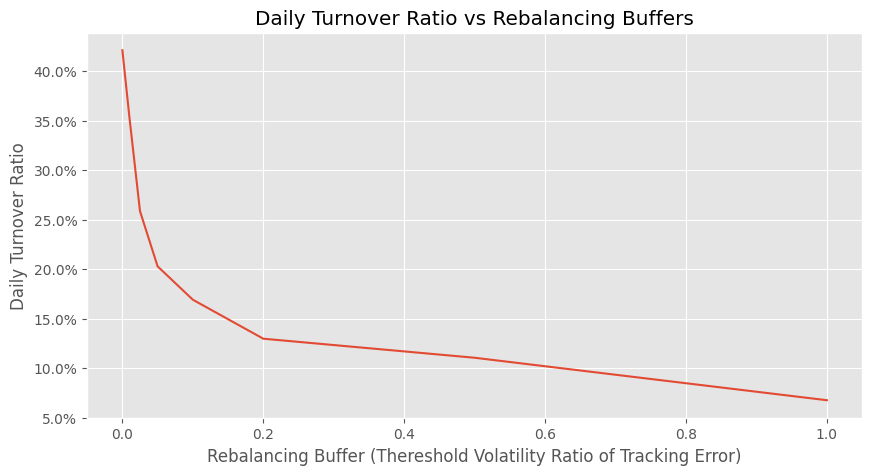

In [15]:
rebals = [0, 0.01, 0.025, 0.05, 0.1, 0.2, 0.5, 1]
tcosts = [0, 0.5, 1, 2]
sharpes = pd.DataFrame(index=tcosts, columns=rebals)
turnovers = pd.Series(index=rebals)
agg_strategy = AggregatedSignal([agg_butterflies, agg_spreads], dates=df_zc.loc['2015':].index)
agg_strategy.estimate_target_risk()
agg_strategy.set_target_volatility(1, df_zc)
for th in rebals:
    trading = SystematicStrategy(agg_strategy, df, price_data, df_zc, rebal_threshold=th, fit_resid=fit_data, time_slippage=1)
    trading.calc_position()
    trading.calc_total_pnl(tcosts[0]/10000)
    turnovers.loc[th] = (trading.trades * trading.dirty_prices).abs().sum(axis=1).sum() / \
        (trading.position * trading.dirty_prices).abs().sum(axis=1).sum()
    sharpes.loc[tcosts[0], th] = np.sqrt(261) * trading.pnl.sum(axis=1).mean() / trading.pnl.sum(axis=1).std()
    for tc in tcosts[1:]:
        trading.calc_total_pnl(tc/10000)
        sharpes.loc[tc, th] = np.sqrt(261) * trading.pnl.sum(axis=1).mean() / trading.pnl.sum(axis=1).std()
sharpes.columns = [str(c) for c in sharpes.columns]
sharpes.index = [str(c) for c in sharpes.index]
sharpes['Best Sharpe'] = sharpes.max(axis=1)

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(turnovers)
ax.set_title('Daily Turnover Ratio vs Rebalancing Buffers')
ax.set_xlabel('Rebalancing Buffer (Thereshold Volatility Ratio of Tracking Error)')
ax.set_ylabel('Daily Turnover Ratio')
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

sharpes.style.format('{:,.2f}').set_properties(**{'background-color': 'grey'}).\
    highlight_max(axis=1, props='color:green;background-color:white').\
    set_caption("Sharpe Ratios for Different Costs and Rebalancing Buffers")

A larger buffer, through decreased turnover, results in a lower sensitivity to transaction costs. Furthermore, as transaction costs increase, the optimal buffer size also grows.


### Conclusion and Further work

I demonstrated how a systematic relative value strategy can be constructed in the MBONOs market. The strategy has a relatively high turnover, making it sensitive to transaction costs. I also showed how the strategy can be adjusted to accommodate higher costs while still maintaining an investable Sharpe ratio.

However, further work is needed on portfolio construction and rebalancing methods to reduce costs and capital utilization. Another important improvement is incorporating carry and roll-down analysis to minimize false positives, especially for steepener/flatteners trades. Following that, I plan to integrate the rate derivatives market into the framework to introduce additional dimensions for alpha opportunities and reduce capital requirements.